# Predicting Occupancy

Author: David D'Haese

## Introduction

The goal of this data analysis report is to reproduce the work published by Candanedo and Feldheim (2016)<sup>1</sup>. The authors have tried to predict the presence of a human in a room based on the reading of 4 sensors measuring light, temperature, humidity and CO<sub>2</sub> concentration. In this preliminary analysis, the focus lays on the predictive capacity of two out of the four sensors (CO<sub>2</sub> and light) using a Gaussian naïve Bayes classifier.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from time import perf_counter
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, plot_roc_curve, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

## Data

The data resides in the file `occupancy.tab` (MD5 after cleaning: `861D2DBBD6DA88C72BA1E56F1A582BBF`) in the `dat` subfolder and was originally collected from the [UCI repository](https://archive.ics.uci.edu/ml/machine-learning-databases/00357/) and then adjusted as follows:

1. Merge test data and training data into single file
2. Rename column headers for the sake of clarity and consistency:
  - `date` &rarr; `Time`
  - `HumidityRatio` &rarr; `Humidity_Ratio`
3. Convert separator comma's to tabs

Of the features of the data set, only the reading from the light and CO<sub>2</sub> sensors will be retained.

In [2]:
data_df = pd.read_csv("dat/occupancy.tab", sep="\t")
feat = data_df[["Light", "CO2"]]
outc = data_df.Occupancy

## Loading and Splitting the Data

The retained data set is split into 2 parts, one for training (&frac23;) and one for testing (&frac13;). The seed was set to 42 to allow for reproduction of this work.

In [ ]:
feat_trai, feat_test, outc_trai, outc_test = train_test_split(
    feat, outc, test_size=0.33, random_state=42)

## Training the Learner

The learner is a default naïve Bayes learner as implemented by the sklearn Python framework. No parametrization has taken place during this step.

In [ ]:
t0 = perf_counter()
learner = GaussianNB()
learner.fit(feat_trai, outc_trai)
t1 = perf_counter()

print(f"Algorithm trained in {t1-t0:.3f} seconds.")

  ## Prediction

  Both the deterministic (threshold: $P = 0.5$) as the probabilistic predictions are being collected for future use.

In [47]:
outc_pred = learner.predict(feat_test)
outc_pred_prob = learner.predict_proba(feat_test)[:, 1]

  ## Visualization of Prediction

  As we are focusing here on two features only, we can plot the the decision boundary overlaid by the test data's true classification:

In [35]:
x_min = feat.Light.min()-100
x_max = feat.Light.max()+100
y_min = feat.CO2.min()-100
y_max = feat.CO2.max()+100
n = 100

x_ax = np.linspace(x_min, x_max, n)
y_ax = np.linspace(y_min, y_max, n)
grid=[[x, y] for y in y_ax for x in x_ax]
z = learner.predict_proba(grid)[:, 1]
z = z.reshape(n, n)

present = outc_test == 1
absent = outc_test == 0

fig_data = [
    {"type": "contour",
        "name": "Prob(Present)",
        "x": x_ax, "y": y_ax, "z": z,
        "showlegend": True,
     "colorscale": [
        [0.0, "lightsteelblue"],
        [0.5, "lightgrey"],
        [1.0, "navajowhite"]]},
    {"type": "scatter",
        "name": "Absent",
        "showlegend": False,
        "mode": "markers",
        "marker": {"size": 3, "color": "steelblue"},
        "x": feat_test.Light.loc[absent],
        "y": feat_test.CO2[absent]},
    {"type": "scatter",
        "name": "Present",
        "showlegend": False,
        "mode": "markers",
        "marker": {"size": 3, "color": "orange"},
        "x": feat_test.Light.loc[present],
        "y": feat_test.CO2[present]}]

fig_layout = {
    "title": "Decision boundary for Naïve Bayes Classifier",
    "xaxis_title": "Light (Lux)",
    "yaxis_title": "CO<sub>2</sub> Concentration (ppm)" }

fig = go.Figure (fig_data, fig_layout)
fig.show()

  ## Algorithm Performance

  First, we measure the absolute accuracy:

In [30]:
performance = accuracy_score(outc_pred, outc_test)
message = "Performance of the classifier when using Light and CO2 " + \
         f"features:\n{performance:.2%}"
print(message)

Performance of the classifier when using Light and CO2 features:
97.35%


Next we display the confusion matrix and calculate a number of additional diagnostics:

In [65]:
cm=confusion_matrix(outc_test, outc_pred, labels=[1, 0])
tp, fp, fn, tn = cm.ravel()
print(cm)
print(f"\nsensitivity = {tp/(tp+fn):.3f}")
print(f"specificity = {tn/(tn+fp):.3f}")
print(f"precision = {tp/(tp+fp):.3f}")

[[1562    4]
 [ 176 5043]]

sensitivity = 0.899
specificity = 0.999
precision = 0.997


The ROC curve below demonstrates the classification success independent of a threshold.

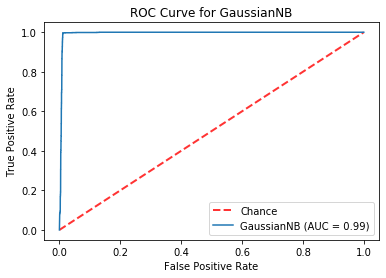

In [54]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
plot_roc_curve(learner, feat_test, outc_test, ax=ax )
ax.set_title('ROC Curve for GaussianNB')
plt.show()

Below the calculation to find the best possible threshold:

In [81]:
fpr, tpr, thresholds = roc_curve(outc_test, outc_pred_prob)
threshold_best=thresholds[np.argmax(tpr-fpr)]
print(f"Best threshold = {threshold_best:.1%}")

Best threshold = 99.4%


## Conclusion

In this report, the goals was to partially reproduce the analysis of Candanedo and Feldheim (2016) using readings from the light and CO<sub>2</sub> sensors only. With an overall performance of 97.35% on a randomly picked test data set (&frac13; of total size), we can say that, based on the presented data, on average less than one in every 35 cases will be wrongly classified.

The confusion matrix was examined to check whether the promising accuracy could not be the result of unbalanced data. Specificity and Precision proved to be near-perfect (99.9% and 99.7%, respectively) while sensitivity was lower (89.9%). Based on these numbers as well as on the plot showing the decision boundary and the ROC curve, it can be concluded that the algorithm used by the learner, however accurate, is somehow biased. Concordingly, the ideal threshold (99.4%) is far from the expected 50%.

Although expected to improve, additional unseen data is required should the bias in the Gaussian naïve Bayes algorithm be corrected and a new optimal accuracy be calculated. Evaluating the optimised algorithm on present data would present with a data leakage issue. Should new data be acquired, it would be recommended to keep apart and additional validation set of instances and evaluate other learners such as decision trees, random forest as well asa simple logistic regression.

  ## References

   1. Candanedo, L. M., & Feldheim, V. (2016). Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Energy and Buildings, 112, 28-39.